Objective: To identify the most significant environmental and temporal factors that influence household appliance energy consumption, and to use these factors to develop an accurate and interpretable machine learning model for energy usage prediction.

First step: Clean the dataset and display a clean version

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

file_path = "KAG_energydata_complete.csv"
df = pd.read_csv(file_path)

# Extract time-based features
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

# Drop the original date column
df.drop(columns=['date'], inplace=True)

# Separate features and target variable
X = df.drop(columns=['Appliances'])
y = df['Appliances']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save feature names
feature_names = X.columns.tolist()

print(df.head(10))

   Appliances  lights         T1       RH_1     T2       RH_2     T3  \
0          60      30  19.890000  47.596667  19.20  44.790000  19.79   
1          60      30  19.890000  46.693333  19.20  44.722500  19.79   
2          50      30  19.890000  46.300000  19.20  44.626667  19.79   
3          50      40  19.890000  46.066667  19.20  44.590000  19.79   
4          60      40  19.890000  46.333333  19.20  44.530000  19.79   
5          50      40  19.890000  46.026667  19.20  44.500000  19.79   
6          60      50  19.890000  45.766667  19.20  44.500000  19.79   
7          60      50  19.856667  45.560000  19.20  44.500000  19.73   
8          60      40  19.790000  45.597500  19.20  44.433333  19.73   
9          70      40  19.856667  46.090000  19.23  44.400000  19.79   

        RH_3         T4       RH_4  ...     RH_out  Windspeed  Visibility  \
0  44.730000  19.000000  45.566667  ...  92.000000   7.000000   63.000000   
1  44.790000  19.000000  45.992500  ...  92.000000   

Next step: Create a Correlation matrix to understand the relationship between features in the dataset. 

This will help us answer the question of which environmental and time-based features have the most impact on appliance energy usage.

In [47]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Appliances'].sort_values(ascending=False)

print("Top 10 features correlated with Appliances:")
print(correlation_with_target[1:11])

Top 10 features correlated with Appliances:
hour         0.216792
lights       0.197278
T2           0.120073
T6           0.117638
T_out        0.099155
Windspeed    0.087122
RH_1         0.086031
T3           0.085060
T1           0.055447
T4           0.040281
Name: Appliances, dtype: float64


To make it more visual we will create a plot of this data.

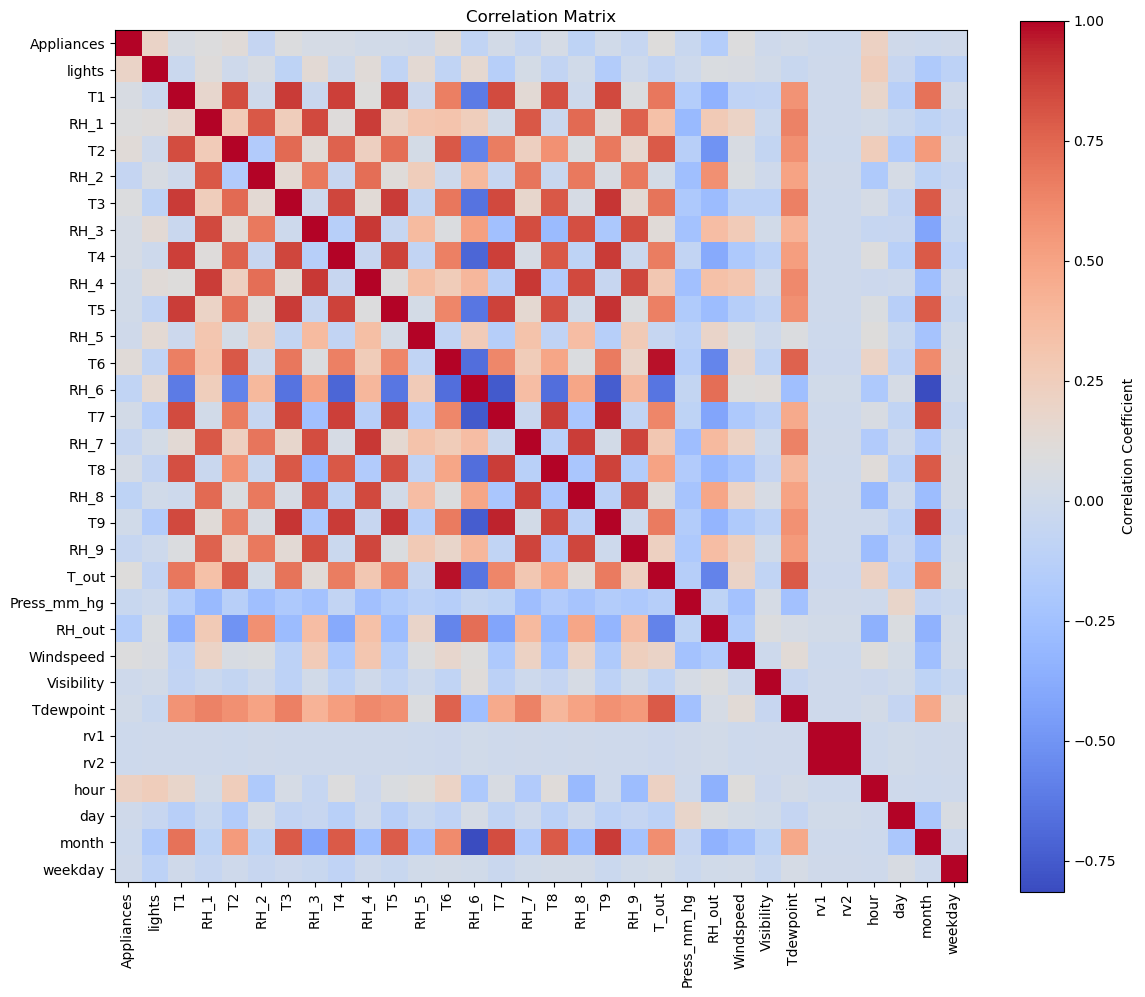

In [48]:
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')

tick_marks = np.arange(len(correlation_matrix.columns))
plt.xticks(tick_marks, correlation_matrix.columns, rotation=90)
plt.yticks(tick_marks, correlation_matrix.columns)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

To check how features affect model performance we will perform a Permutation Feature Importance test on the Random Forrest model

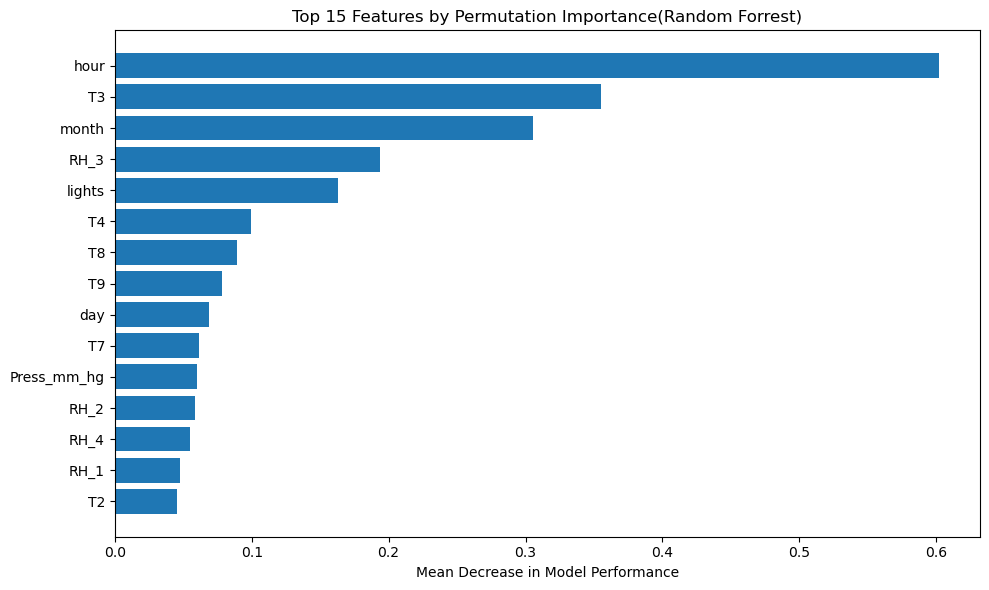

In [49]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train_scaled, y_train)

result = permutation_importance(rf_model, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)
rf_importances = result.importances_mean
indices = np.argsort(rf_importances)[::-1]
features = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.barh(range(15), rf_importances[indices][:15], align='center')
plt.yticks(range(15), features[:15])
plt.xlabel("Mean Decrease in Model Performance")
plt.title("Top 15 Features by Permutation Importance(Random Forrest)")
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()

Next step is to do the same on the linear regression model.

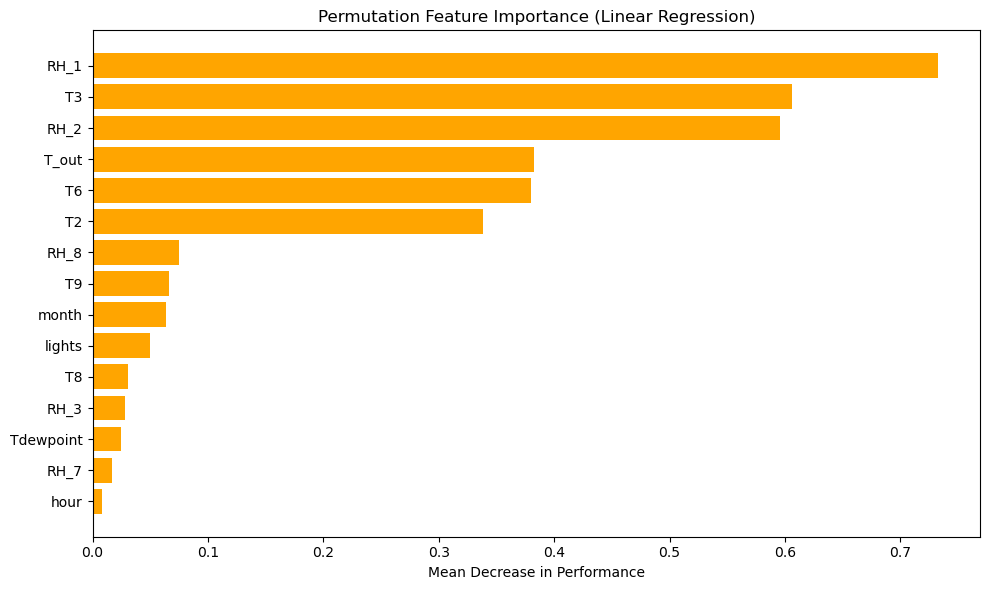

In [56]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

perm_result = permutation_importance(
    lr_model, X_test_scaled, y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

lr_importances = perm_result.importances_mean
indices = np.argsort(lr_importances)[::-1]
feature_names = X.columns[indices]

top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), lr_importances[indices[:top_n]], color='orange')
plt.yticks(range(top_n), feature_names[:top_n])
plt.xlabel("Mean Decrease in Performance")
plt.title("Permutation Feature Importance (Linear Regression)")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.tight_layout()
plt.show()

Finally we will check Permutation Feature Importance on the last model Gradient Boosting

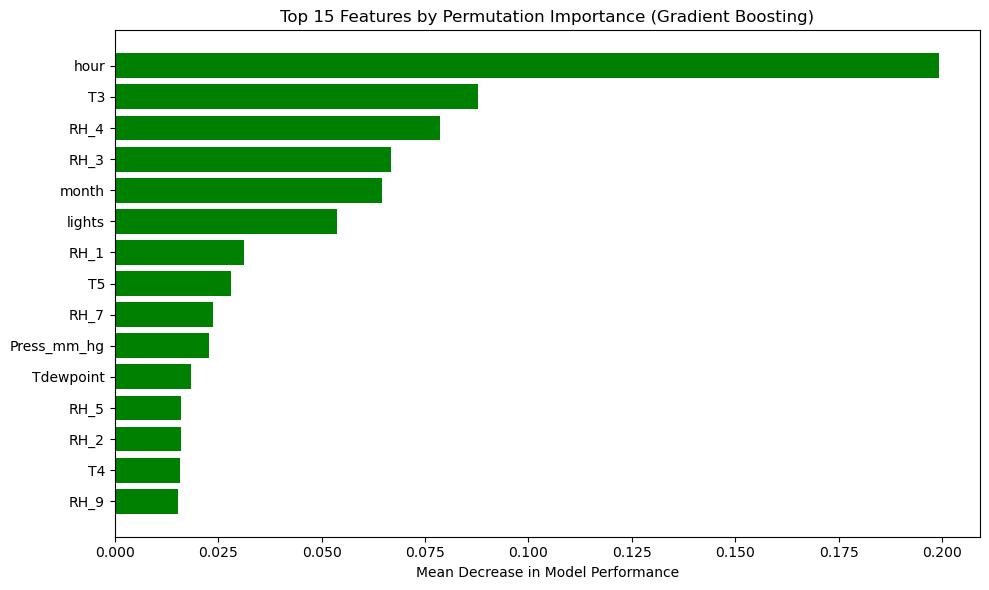

In [51]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

gb_result = permutation_importance(gb_model, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)
gb_importances = gb_result.importances_mean
gb_indices = np.argsort(gb_importances)[::-1]
gb_features = X.columns[gb_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(15), gb_importances[gb_indices][:15], align='center', color='green')
plt.yticks(range(15), gb_features[:15])
plt.xlabel("Mean Decrease in Model Performance")
plt.title("Top 15 Features by Permutation Importance (Gradient Boosting)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Lastly we will compare the three models against eachother. 

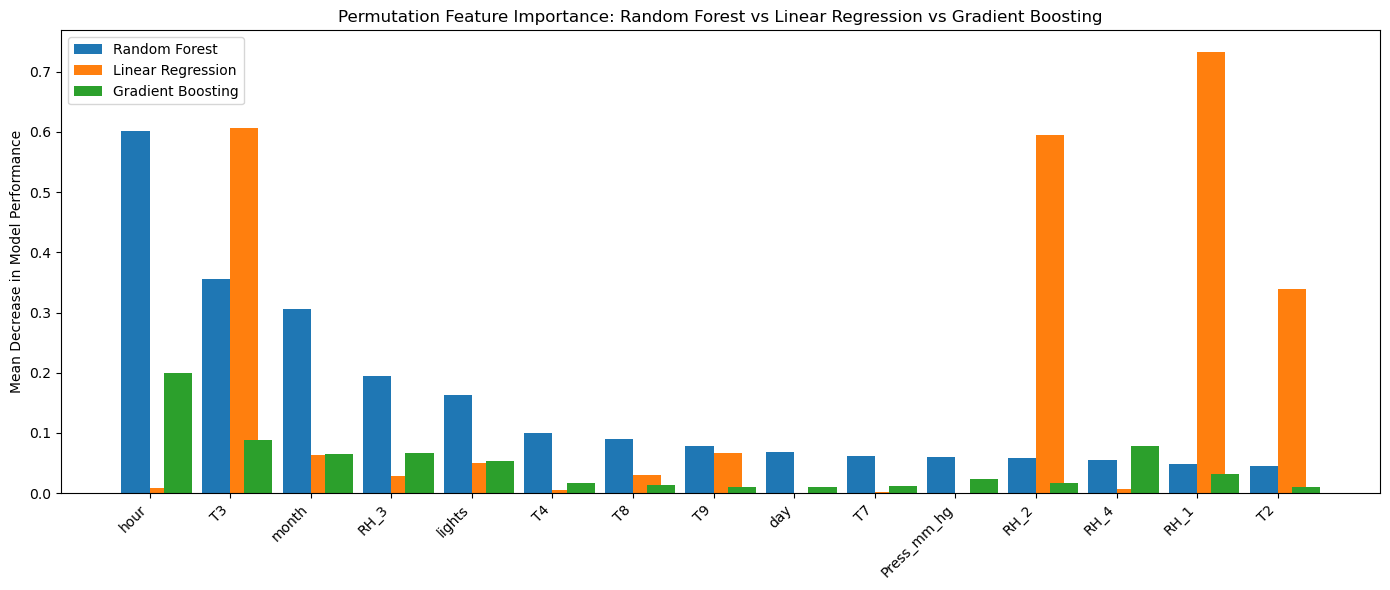

In [52]:
features = X.columns
df_compare = pd.DataFrame({
    'Feature': features,
    'Random Forest': rf_importances,
    'Linear Regression': lr_importances,
    'Gradient Boosting': gb_importances
}).set_index('Feature')

df_compare_sorted = df_compare.sort_values(by='Random Forest', ascending=False)
top_features = df_compare_sorted.head(15)

x = np.arange(len(top_features))
bar_width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - bar_width/2, top_features['Random Forest'], width=bar_width, label='Random Forest')
plt.bar(x + bar_width/2, top_features['Linear Regression'], width=bar_width, label='Linear Regression')
plt.bar(x + bar_width, top_features['Gradient Boosting'], width=bar_width, label='Gradient Boosting')

plt.xticks(x, top_features.index, rotation=45, ha='right')
plt.ylabel('Mean Decrease in Model Performance')
plt.title('Permutation Feature Importance: Random Forest vs Linear Regression vs Gradient Boosting')
plt.legend()
plt.tight_layout()
plt.show()

This shows us that Random Forest is likely the better model of the three, to use on our dataset. 

It considers more features and gives a more balanced feature importance profile. 

To confirm our results we will compare the R² Score of all models

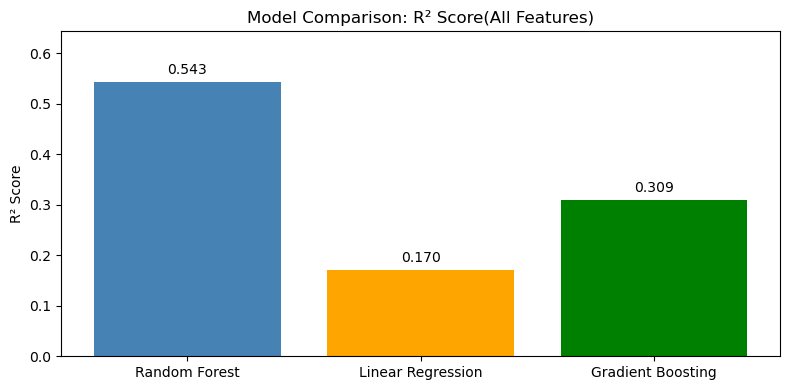

In [64]:
rf_model.fit(X_train_scaled, y_train)
lr_model.fit(X_train_scaled, y_train)
gb_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_gb = gb_model.predict(X_test_scaled)

r2_rf = r2_score(y_test, y_pred_rf)
r2_lr = r2_score(y_test, y_pred_lr)
r2_gb = r2_score(y_test, y_pred_gb)

models = ['Random Forest', 'Linear Regression', 'Gradient Boosting']
scores = [r2_rf, r2_lr, r2_gb]

plt.figure(figsize=(8, 4))
bars = plt.bar(models, scores, color=['steelblue', 'orange', 'green'])
plt.ylabel('R² Score')
plt.title('Model Comparison: R² Score(All Features)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()

The Linear Regression model achieved an R² score of 0.170, indicating a weak performance of only 17% variance

In contrast, the Random Forest model achieved a significantly higher R² score of 0.543, indicating a higher performance with 54% variance

Lastly Gradient Boosting has a decent performance of 0.309, indicating 31% of variance

Out of the three models, Random Forrest should be the final choice. It significantly outperforms both Linear Regression and Gradient Boosting in terms of predictive accuracy. The gap shows that non-linear, tree-based models are better suited to this type of energy usage prediction task.

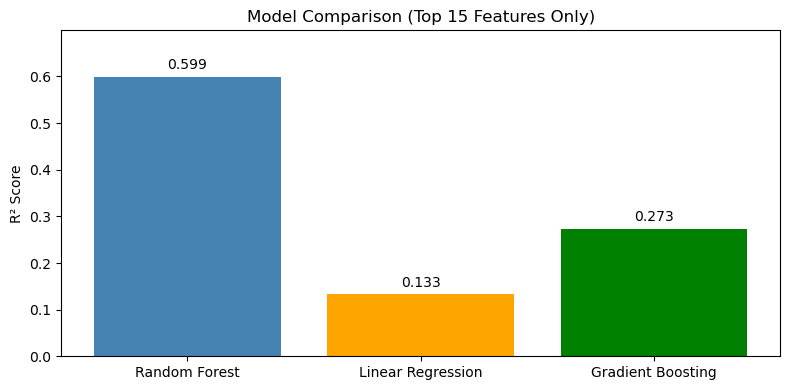

In [67]:
X_top = X[top_features]
X_top_train, X_top_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

scaler_top = StandardScaler()
X_top_train_scaled = scaler_top.fit_transform(X_top_train)
X_top_test_scaled = scaler_top.transform(X_top_test)

rf_top = RandomForestRegressor(n_estimators=50, random_state=42)
lr_top = LinearRegression()
gb_top = GradientBoostingRegressor(n_estimators=100, random_state=42)

rf_top.fit(X_top_train_scaled, y_train)
lr_top.fit(X_top_train_scaled, y_train)
gb_top.fit(X_top_train_scaled, y_train)

y_pred_rf_top = rf_top.predict(X_top_test_scaled)
y_pred_lr_top = lr_top.predict(X_top_test_scaled)
y_pred_gb_top = gb_top.predict(X_top_test_scaled)

r2_rf_top = r2_score(y_test, y_pred_rf_top)
r2_lr_top = r2_score(y_test, y_pred_lr_top)
r2_gb_top = r2_score(y_test, y_pred_gb_top)

models = ['Random Forest', 'Linear Regression', 'Gradient Boosting']
scores = [r2_rf_top, r2_lr_top, r2_gb_top]

plt.figure(figsize=(8, 4))
bars = plt.bar(models, scores, color=['steelblue', 'orange', 'green'])
plt.ylabel('R² Score')
plt.title('Model Comparison (Top 15 Features Only)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()

With top 15 features, Random Forest continues to perform the best even with fewer features. 

Linear Regression again performs the worst likely due to its limited ability to capture complex, non-linear relationships.

Gradient Boosting has also slighty decreased in R2 score compared to when it had more features

Lets make a side-by-side comparison to make it even more clear.

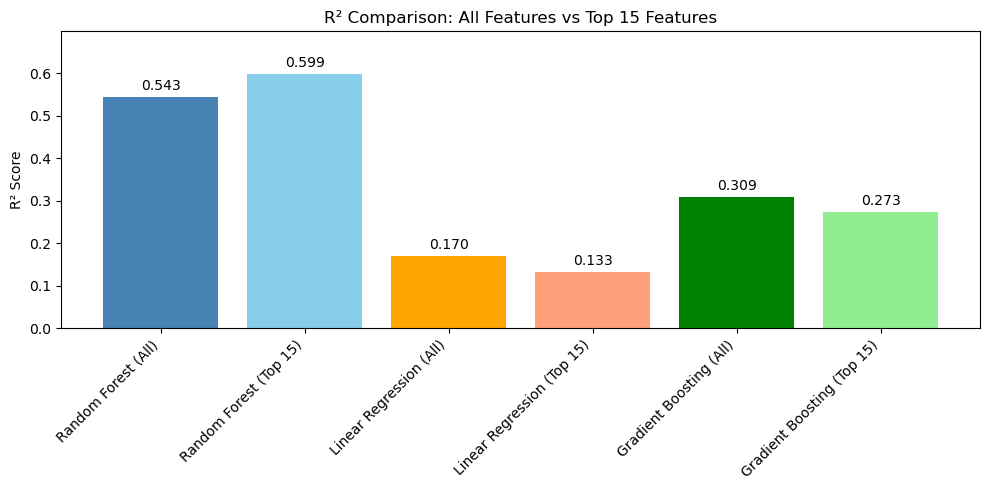

In [68]:
models_extended = [
    'Random Forest (All)', 'Random Forest (Top 15)',
    'Linear Regression (All)', 'Linear Regression (Top 15)',
    'Gradient Boosting (All)', 'Gradient Boosting (Top 15)'
]

scores_combined = [
    r2_all, r2_rf_top,
    r2_lr, r2_lr_top,
    r2_gb, r2_gb_top
]

colors_combined = ['steelblue', 'skyblue', 'orange', 'lightsalmon', 'green', 'lightgreen']

plt.figure(figsize=(10, 5))
bars = plt.bar(models_extended, scores_combined, color=colors_combined)
plt.ylabel('R² Score')
plt.title('R² Comparison: All Features vs Top 15 Features')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylim(0, max(scores_combined) + 0.1)
plt.tight_layout()
plt.show()

Lastly we will train our model on Random Forrest with top 15 features, all features and then compare the two with an R² comparrison and then a risidual analysis.

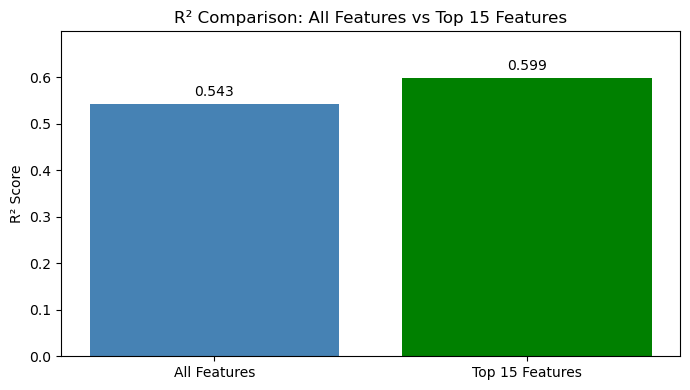

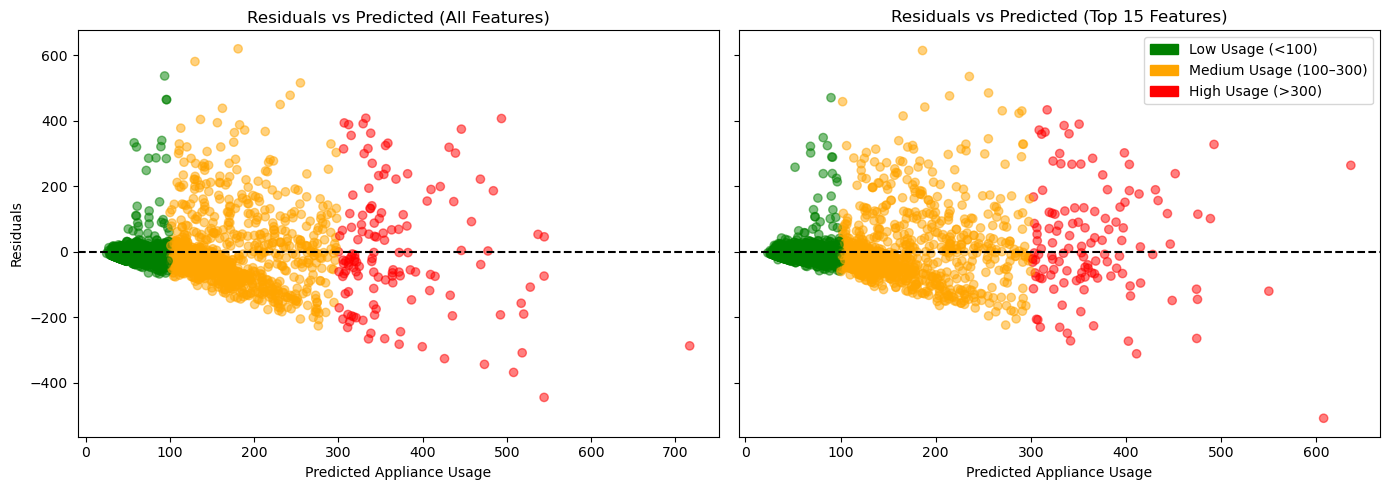

In [63]:
rf_all = RandomForestRegressor(n_estimators=50, random_state=42)
rf_all.fit(X_train_scaled, y_train)
y_pred_all = rf_all.predict(X_test_scaled)
r2_all = r2_score(y_test, y_pred_all)

importances = rf_all.feature_importances_
top_indices = np.argsort(importances)[::-1][:15]
top_features = X.columns[top_indices]

X_top_train = X_train[top_features]
X_top_test = X_test[top_features]

scaler_top = StandardScaler()
X_top_train_scaled = scaler_top.fit_transform(X_top_train)
X_top_test_scaled = scaler_top.transform(X_top_test)

rf_top = RandomForestRegressor(n_estimators=50, random_state=42)
rf_top.fit(X_top_train_scaled, y_train)
y_pred_top = rf_top.predict(X_top_test_scaled)
r2_top = r2_score(y_test, y_pred_top)

models = ['All Features', 'Top 15 Features']
scores = [r2_all, r2_top]

plt.figure(figsize=(7, 4))
bars = plt.bar(models, scores, color=['steelblue', 'green'])
plt.ylabel("R² Score")
plt.title("R² Comparison: All Features vs Top 15 Features")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()

residuals_all = y_test - y_pred_all

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

colors_all = np.where(y_pred_all < 100, 'green',
              np.where(y_pred_all < 300, 'orange', 'red'))


axes[0].scatter(y_pred_all, residuals_all, alpha=0.5, c=colors_all)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title("Residuals vs Predicted (All Features)")
axes[0].set_xlabel("Predicted Appliance Usage")
axes[0].set_ylabel("Residuals")

axes[1].scatter(y_pred_top, residuals, alpha=0.5, c=colors)
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title("Residuals vs Predicted (Top 15 Features)")
axes[1].set_xlabel("Predicted Appliance Usage")

green_patch = mpatches.Patch(color='green', label='Low Usage (<100)')
orange_patch = mpatches.Patch(color='orange', label='Medium Usage (100–300)')
red_patch = mpatches.Patch(color='red', label='High Usage (>300)')
axes[1].legend(handles=[green_patch, orange_patch, red_patch])

plt.tight_layout()
plt.show()


As we can see our top 15 feature model not only performs better on R² score, but has more consistent residuals especially in high-usage zones — which is crucial for a real-world energy forecasting models.